In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from clean_velocities import *
from klusterointi import *
from yellowbrick.cluster import KElbowVisualizer


### Import data

In [2]:
df = database_query("SELECT * FROM DATA")
df

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour
0,2,1,2020-06-25 15:21:46,28,15,628,0.962081,6812.007,3,8
1,2,1,2020-06-25 15:21:47,28,15,628,1.028834,6812.007,3,8
2,2,1,2020-06-25 15:21:47,28,15,628,0.648460,6812.007,3,8
3,2,1,2020-06-25 15:21:47,28,15,628,0.826075,6812.007,3,8
4,2,1,2020-06-25 15:21:50,26,15,626,1.753767,6812.007,3,8
...,...,...,...,...,...,...,...,...,...,...
2761246,8956,31,2020-09-22 14:41:04,19,16,659,0.608769,97.531,1,7
2761247,8956,31,2020-09-22 14:41:05,19,16,659,0.743303,97.531,1,7
2761248,8956,31,2020-09-22 14:41:06,18,16,658,0.594138,97.531,1,7
2761249,8956,31,2020-09-22 14:41:11,1,28,1121,28.712454,97.531,1,7


### Sum distances to got overall lenght of the shopping trip

In [3]:
distances = df.groupby(['ajokerta'])['distance'].sum().to_dict()
df["distance"] = df['ajokerta'].map(distances)
df

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour
0,2,1,2020-06-25 15:21:46,28,15,628,582.077564,6812.007,3,8
1,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8
2,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8
3,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8
4,2,1,2020-06-25 15:21:50,26,15,626,582.077564,6812.007,3,8
...,...,...,...,...,...,...,...,...,...,...
2761246,8956,31,2020-09-22 14:41:04,19,16,659,93.673832,97.531,1,7
2761247,8956,31,2020-09-22 14:41:05,19,16,659,93.673832,97.531,1,7
2761248,8956,31,2020-09-22 14:41:06,18,16,658,93.673832,97.531,1,7
2761249,8956,31,2020-09-22 14:41:11,1,28,1121,93.673832,97.531,1,7


### Create list, which lenght matches amount of grid_ids and check, which ids shopping trip does have in it.

In [4]:
%%time
grid = np.arange(0,1600,1)
kaikki = []
for ajo in df["ajokerta"].unique():

    kaynyt = []
    kerta = df[df["ajokerta"] == ajo]["grid_id"].unique() 
    [kaynyt.append(1) if x in kerta else kaynyt.append(0) for x in grid]
    kaikki.append(kaynyt)


CPU times: user 56.1 s, sys: 5.18 ms, total: 56.1 s
Wall time: 56.1 s


### Use PCA to find IDs that explain overall variance on all trips.

CPU times: user 19.5 s, sys: 3.94 s, total: 23.5 s
Wall time: 4.36 s


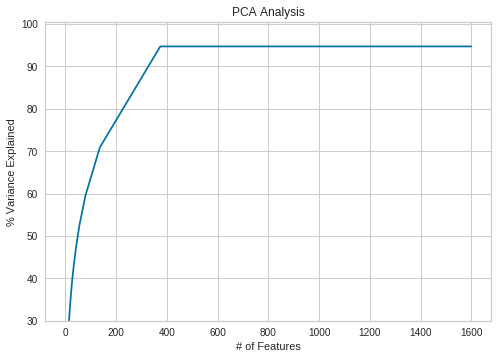

In [5]:
%%time
# https://etav.github.io/python/scikit_pca.html
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=1600)
pca.fit(kaikki)

exp = pca.explained_variance_ratio_
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var);

In [6]:
pca = PCA(0.9)
pca.fit(kaikki)

test  = pca.transform(kaikki)
# print("Features left after PCA:",len(test[0]))
print("original shape:   ", len(kaikki[0]))
print("transformed shape:", len(test[0]))

original shape:    1600
transformed shape: 363


### Create new dataframe from PCA components 

In [7]:
pca_features = pd.DataFrame(data = test, columns = [f"{x}" for x in np.arange(0,len(test[1]),1)])
pca_features

,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,360,361,362
0,0.875347,-0.306856,2.807168,1.955991,-0.673819,2.307539,1.505638,1.697960,0.038105,1.227756,...,0.529104,0.321088,0.580783,-0.249629,0.426535,0.158528,-0.343032,-0.033834,0.092608,0.168414
1,-0.500468,1.789629,-1.047766,-0.779526,1.314123,1.525012,0.780928,-0.847197,-0.094212,2.235440,...,0.323529,0.009662,0.351207,0.118637,0.046734,0.090546,-0.072379,-0.272353,0.200882,-0.263746
2,2.477709,1.643704,-1.101729,-1.326805,0.696344,-0.531020,0.028748,0.851182,-0.864660,-0.865503,...,0.329635,-0.309033,-0.020795,-0.114183,0.508509,0.163384,0.854329,0.136828,0.377092,-0.255177
3,0.471352,-0.543992,0.200196,-0.442099,0.618230,-2.364667,0.208763,-0.725448,-0.842588,-0.136152,...,0.066371,0.031877,-0.139164,0.169778,0.280947,0.112437,-0.156827,-0.151620,0.045269,0.134477
4,0.701635,-0.195453,-0.094510,-1.054007,0.158500,-2.190897,0.593102,0.616214,0.403174,0.091288,...,0.606948,-0.192871,0.288317,-0.187403,-0.164337,0.508173,-0.032199,0.167482,0.210204,0.069430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7273,-3.816170,-0.686229,0.696790,0.529457,1.823716,0.039907,-0.227829,0.847163,0.344998,-1.549206,...,0.125972,0.055359,-0.021132,0.026301,-0.119261,0.245277,-0.068776,-0.061192,0.071364,-0.202136
7274,-2.982812,-1.503352,1.259109,0.280158,3.207773,0.335279,-0.047746,0.021905,0.152367,0.896765,...,-0.070296,-0.031509,-0.247208,0.186232,-0.309010,0.065551,0.079430,-0.000970,0.004017,0.128086
7275,2.317297,0.866048,1.957563,-1.213595,1.067256,-1.118499,1.438702,0.131608,-0.476897,-2.303970,...,0.437177,0.256442,-0.093091,-0.256095,-0.128553,-0.255793,0.273965,-0.011458,-0.044234,-0.108022
7276,0.190435,-2.462613,-1.907296,-1.878730,-1.452492,0.533105,0.521049,2.465172,0.277858,-0.917844,...,0.077375,0.130869,0.153211,-0.174399,0.034659,-0.063030,-0.034342,-0.336447,-0.357568,0.035321


### Create Feature matrix from cleaned data

In [8]:
%%time
def df_to_features(df):
    df["check"] = df["ajokerta"].shift(1)
    uniques = df["ajokerta"].unique()
    rivit = []
    asd = pd.DataFrame()
    for row in df.itertuples():
        if row.ajokerta != row.check:
            rivit.append({"ajokerta":row.ajokerta, 
                          "node_id":row.node_id, 
                          "kesto":row.kesto, 
                          "dayofweek":row.dayofweek,
                          "current_hour":row.current_hour, 
                          "distance":row.distance})
            
    return pd.DataFrame(rivit)
features = df_to_features(df)

print(len(features))
print(len(pca_features))

7278
7278
CPU times: user 8.85 s, sys: 181 ms, total: 9.03 s
Wall time: 8.75 s


### Add features from pca to feature matrix

In [9]:
data = pd.concat([features, pca_features], axis=1, sort=False)
data

,ajokerta,node_id,kesto,dayofweek,current_hour,distance,0,1,2,3,...,353,354,355,356,357,358,359,360,361,362
0,2,1,6812.007,3,8,582.077564,0.875347,-0.306856,2.807168,1.955991,...,0.529104,0.321088,0.580783,-0.249629,0.426535,0.158528,-0.343032,-0.033834,0.092608,0.168414
1,3,1,1121.998,3,9,219.936854,-0.500468,1.789629,-1.047766,-0.779526,...,0.323529,0.009662,0.351207,0.118637,0.046734,0.090546,-0.072379,-0.272353,0.200882,-0.263746
2,4,1,769.999,3,10,349.979207,2.477709,1.643704,-1.101729,-1.326805,...,0.329635,-0.309033,-0.020795,-0.114183,0.508509,0.163384,0.854329,0.136828,0.377092,-0.255177
3,5,1,265.000,3,12,207.363103,0.471352,-0.543992,0.200196,-0.442099,...,0.066371,0.031877,-0.139164,0.169778,0.280947,0.112437,-0.156827,-0.151620,0.045269,0.134477
4,7,1,660.002,4,12,367.454784,0.701635,-0.195453,-0.094510,-1.054007,...,0.606948,-0.192871,0.288317,-0.187403,-0.164337,0.508173,-0.032199,0.167482,0.210204,0.069430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7273,8948,31,645.998,4,10,156.599509,-3.816170,-0.686229,0.696790,0.529457,...,0.125972,0.055359,-0.021132,0.026301,-0.119261,0.245277,-0.068776,-0.061192,0.071364,-0.202136
7274,8950,31,1239.000,5,5,579.244362,-2.982812,-1.503352,1.259109,0.280158,...,-0.070296,-0.031509,-0.247208,0.186232,-0.309010,0.065551,0.079430,-0.000970,0.004017,0.128086
7275,8954,31,2287.001,0,7,234.295562,2.317297,0.866048,1.957563,-1.213595,...,0.437177,0.256442,-0.093091,-0.256095,-0.128553,-0.255793,0.273965,-0.011458,-0.044234,-0.108022
7276,8955,31,3745.999,0,9,156.742423,0.190435,-2.462613,-1.907296,-1.878730,...,0.077375,0.130869,0.153211,-0.174399,0.034659,-0.063030,-0.034342,-0.336447,-0.357568,0.035321


### Now its time to choose, in which point of view we want to cluster shopping trips.

### At first, lets try to cluster similar looking shopping routes to same clusters
##### TODO: 
##### 1) drop unimportant columns
##### 2) standardize data
##### 3) Clustering
##### 3.1) K-Means
###### 3.1.1) Number of clusters
###### - Elbow method, Silhouette score, Calinski Harabasz Score
###### 3.1.2 Results
##### 3.2) K-Medoids
###### 3.2.1) Number of clusters
###### - Elbow method, Silhouette score, Calinski Harabasz Score
###### 3.2.2 Results

#### 1) drop unimportant columns

In [10]:
cluster_df = data.drop(columns=["ajokerta", "node_id", "dayofweek", "current_hour"])
cluster_df

,kesto,distance,0,1,2,3,4,5,6,7,...,353,354,355,356,357,358,359,360,361,362
0,6812.007,582.077564,0.875347,-0.306856,2.807168,1.955991,-0.673819,2.307539,1.505638,1.697960,...,0.529104,0.321088,0.580783,-0.249629,0.426535,0.158528,-0.343032,-0.033834,0.092608,0.168414
1,1121.998,219.936854,-0.500468,1.789629,-1.047766,-0.779526,1.314123,1.525012,0.780928,-0.847197,...,0.323529,0.009662,0.351207,0.118637,0.046734,0.090546,-0.072379,-0.272353,0.200882,-0.263746
2,769.999,349.979207,2.477709,1.643704,-1.101729,-1.326805,0.696344,-0.531020,0.028748,0.851182,...,0.329635,-0.309033,-0.020795,-0.114183,0.508509,0.163384,0.854329,0.136828,0.377092,-0.255177
3,265.000,207.363103,0.471352,-0.543992,0.200196,-0.442099,0.618230,-2.364667,0.208763,-0.725448,...,0.066371,0.031877,-0.139164,0.169778,0.280947,0.112437,-0.156827,-0.151620,0.045269,0.134477
4,660.002,367.454784,0.701635,-0.195453,-0.094510,-1.054007,0.158500,-2.190897,0.593102,0.616214,...,0.606948,-0.192871,0.288317,-0.187403,-0.164337,0.508173,-0.032199,0.167482,0.210204,0.069430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7273,645.998,156.599509,-3.816170,-0.686229,0.696790,0.529457,1.823716,0.039907,-0.227829,0.847163,...,0.125972,0.055359,-0.021132,0.026301,-0.119261,0.245277,-0.068776,-0.061192,0.071364,-0.202136
7274,1239.000,579.244362,-2.982812,-1.503352,1.259109,0.280158,3.207773,0.335279,-0.047746,0.021905,...,-0.070296,-0.031509,-0.247208,0.186232,-0.309010,0.065551,0.079430,-0.000970,0.004017,0.128086
7275,2287.001,234.295562,2.317297,0.866048,1.957563,-1.213595,1.067256,-1.118499,1.438702,0.131608,...,0.437177,0.256442,-0.093091,-0.256095,-0.128553,-0.255793,0.273965,-0.011458,-0.044234,-0.108022
7276,3745.999,156.742423,0.190435,-2.462613,-1.907296,-1.878730,-1.452492,0.533105,0.521049,2.465172,...,0.077375,0.130869,0.153211,-0.174399,0.034659,-0.063030,-0.034342,-0.336447,-0.357568,0.035321


#### 2) standardize data

In [11]:
from sklearn.preprocessing import StandardScaler
std_df = StandardScaler().fit_transform(cluster_df)
std_df = pd.DataFrame(std_df)
std_df

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,3.663815,2.174039,0.404856,-0.189687,1.911357,1.410856,-0.528813,1.925315,1.313480,1.553632,...,2.549949,1.549815,2.808700,-1.208526,2.066556,0.770645,-1.668063,-0.164724,0.451229,0.824369
1,-0.237955,-0.096795,-0.231471,1.106283,-0.713407,-0.562272,1.031323,1.272407,0.681261,-0.775185,...,1.559208,0.046638,1.698460,0.574357,0.226424,0.440168,-0.351958,-1.325960,0.978789,-1.291010
2,-0.479328,0.718647,1.145964,1.016077,-0.750150,-0.957024,0.546490,-0.443061,0.025079,0.778832,...,1.588637,-1.491627,-0.100566,-0.552794,2.463721,0.794250,4.154353,0.666149,1.837360,-1.249066
3,-0.825618,-0.175639,0.218004,-0.336276,0.136310,-0.318886,0.485186,-1.972980,0.182119,-0.663785,...,0.319865,0.153861,-0.673006,0.821944,1.361185,0.546583,-0.762605,-0.738166,0.220568,0.658250
4,-0.554756,0.828229,0.324513,-0.120822,-0.064350,-0.760255,0.124391,-1.827994,0.517407,0.563835,...,2.925108,-0.930943,1.394318,-0.907272,-0.796211,2.470357,-0.156577,0.815389,1.024208,0.339852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7273,-0.564359,-0.493957,-1.765014,-0.424202,0.474434,0.381898,1.431251,0.033297,-0.198752,0.775153,...,0.607106,0.267205,-0.102194,0.127330,-0.577820,1.192353,-0.334438,-0.297915,0.347717,-0.989436
7274,-0.157724,2.156273,-1.379578,-0.929317,0.857308,0.202078,2.517458,0.279743,-0.041652,0.020043,...,-0.338785,-0.152087,-1.195511,0.901604,-1.497148,0.318660,0.386247,-0.004721,0.019570,0.626966
7275,0.560915,-0.006757,1.071772,0.535359,1.332874,-0.875366,0.837582,-0.933230,1.255086,0.120421,...,2.106920,1.237785,-0.450194,-1.239832,-0.622837,-1.243474,1.332213,-0.055783,-0.215527,-0.528755
7276,1.561383,-0.493061,0.088078,-1.522296,-1.298649,-1.355128,-1.139914,0.444800,0.454549,2.255632,...,0.372901,0.631672,0.740936,-0.844316,0.167925,-0.306405,-0.166994,-1.637999,-1.742232,0.172893


### 3) Clustering

### K-Means Clustering

### Number of clusters
###### https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
#### Elbow Method

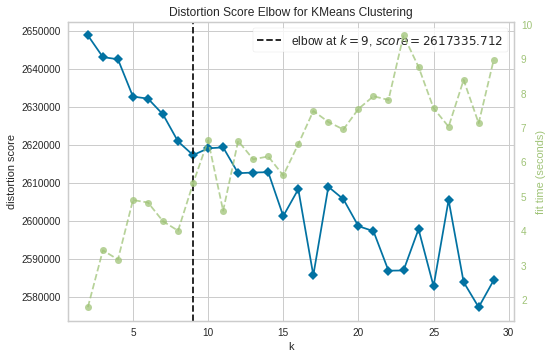

CPU times: user 5min 9s, sys: 2min 8s, total: 7min 17s
Wall time: 2min 58s


In [12]:
%%time
kmeans = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,30), timings= True)
visualizer.fit(std_df)        # Fit data to visualizer
visualizer.show()       # Finalize and render figure
plt.show()

#### Silhouette Score

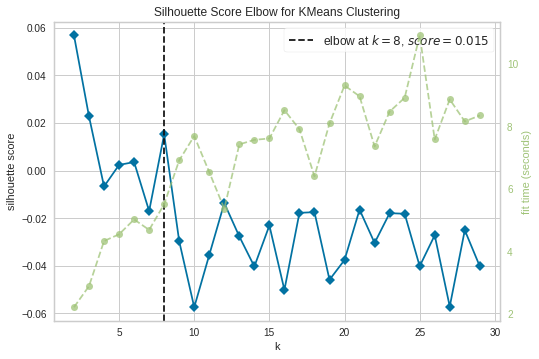

CPU times: user 6min 3s, sys: 2min 5s, total: 8min 8s
Wall time: 3min 40s


In [13]:
%%time
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(std_df)        # Fit the data to the visualizer
visualizer.show()      # Finalize and render the figure
plt.show()

#### Calinski Harabasz Score

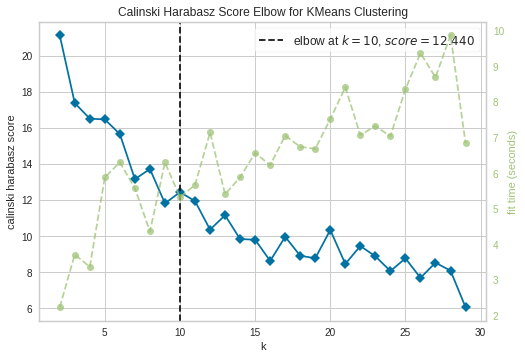

CPU times: user 5min 4s, sys: 1min 54s, total: 6min 58s
Wall time: 3min 2s


In [14]:
%%time
visualizer = KElbowVisualizer(kmeans, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(std_df)        # Fit the data to the visualizer
visualizer.show()    # Finalize and render the figure
plt.show()

In [20]:
# Suggested number of clusters were 8,9,10, se lets choose the middle value for now.
kmeans = KMeans(n_clusters=9, random_state=0).fit(std_df)
y_pred= kmeans.labels_

#### Add predictions to feature dataframe, to be able to get predictions to original dataframe via "ajokerta" column.

In [21]:
data["pred"] = y_pred

In [22]:
data

,ajokerta,node_id,kesto,dayofweek,current_hour,distance,0,1,2,3,...,354,355,356,357,358,359,360,361,362,pred
0,2,1,6812.007,3,8,582.077564,0.875347,-0.306856,2.807168,1.955991,...,0.321088,0.580783,-0.249629,0.426535,0.158528,-0.343032,-0.033834,0.092608,0.168414,5
1,3,1,1121.998,3,9,219.936854,-0.500468,1.789629,-1.047766,-0.779526,...,0.009662,0.351207,0.118637,0.046734,0.090546,-0.072379,-0.272353,0.200882,-0.263746,3
2,4,1,769.999,3,10,349.979207,2.477709,1.643704,-1.101729,-1.326805,...,-0.309033,-0.020795,-0.114183,0.508509,0.163384,0.854329,0.136828,0.377092,-0.255177,8
3,5,1,265.000,3,12,207.363103,0.471352,-0.543992,0.200196,-0.442099,...,0.031877,-0.139164,0.169778,0.280947,0.112437,-0.156827,-0.151620,0.045269,0.134477,6
4,7,1,660.002,4,12,367.454784,0.701635,-0.195453,-0.094510,-1.054007,...,-0.192871,0.288317,-0.187403,-0.164337,0.508173,-0.032199,0.167482,0.210204,0.069430,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7273,8948,31,645.998,4,10,156.599509,-3.816170,-0.686229,0.696790,0.529457,...,0.055359,-0.021132,0.026301,-0.119261,0.245277,-0.068776,-0.061192,0.071364,-0.202136,6
7274,8950,31,1239.000,5,5,579.244362,-2.982812,-1.503352,1.259109,0.280158,...,-0.031509,-0.247208,0.186232,-0.309010,0.065551,0.079430,-0.000970,0.004017,0.128086,8
7275,8954,31,2287.001,0,7,234.295562,2.317297,0.866048,1.957563,-1.213595,...,0.256442,-0.093091,-0.256095,-0.128553,-0.255793,0.273965,-0.011458,-0.044234,-0.108022,6
7276,8955,31,3745.999,0,9,156.742423,0.190435,-2.462613,-1.907296,-1.878730,...,0.130869,0.153211,-0.174399,0.034659,-0.063030,-0.034342,-0.336447,-0.357568,0.035321,0


In [23]:
# https://stackoverflow.com/questions/17426292/what-is-the-most-efficient-way-to-create-a-dictionary-of-two-pandas-dataframe-co

df["pred"] = df['ajokerta'].map(dict(zip(data.ajokerta,data.pred)))
df["pred"].value_counts()

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour,check,pred
0,2,1,2020-06-25 15:21:46,28,15,628,582.077564,6812.007,3,8,NaN,5
1,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,5
2,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,5
3,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,5
4,2,1,2020-06-25 15:21:50,26,15,626,582.077564,6812.007,3,8,2.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2761246,8956,31,2020-09-22 14:41:04,19,16,659,93.673832,97.531,1,7,8956.0,5
2761247,8956,31,2020-09-22 14:41:05,19,16,659,93.673832,97.531,1,7,8956.0,5
2761248,8956,31,2020-09-22 14:41:06,18,16,658,93.673832,97.531,1,7,8956.0,5
2761249,8956,31,2020-09-22 14:41:11,1,28,1121,93.673832,97.531,1,7,8956.0,5


### Results

#### Plot first 10 classified routes

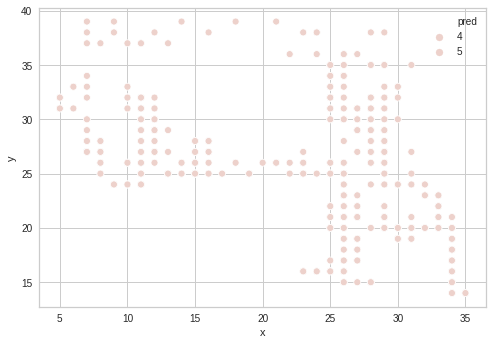

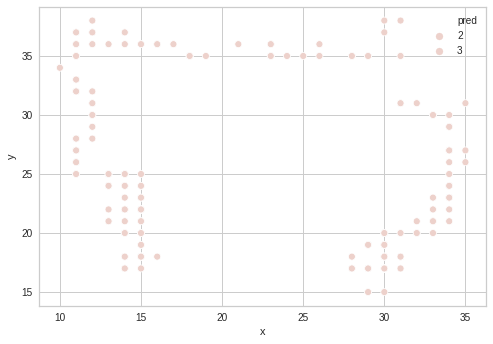

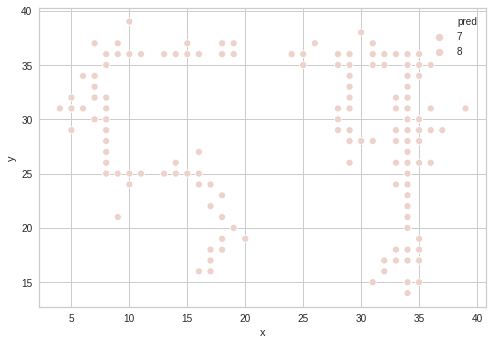

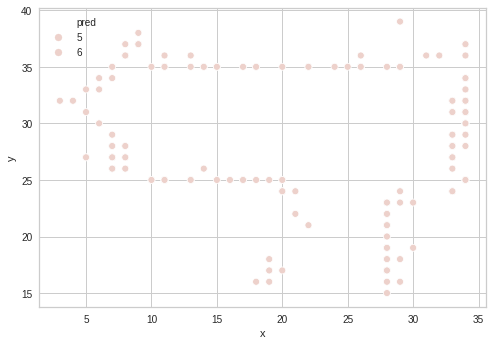

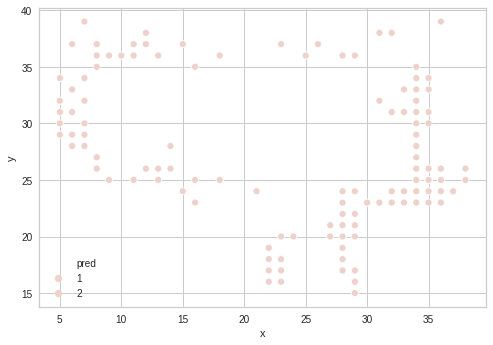

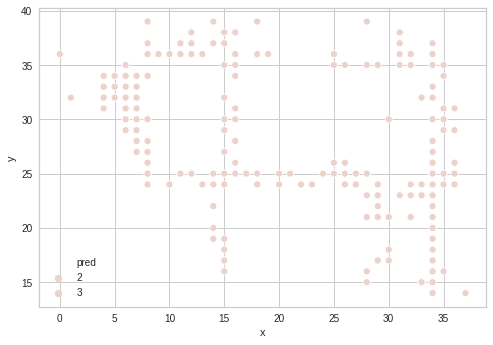

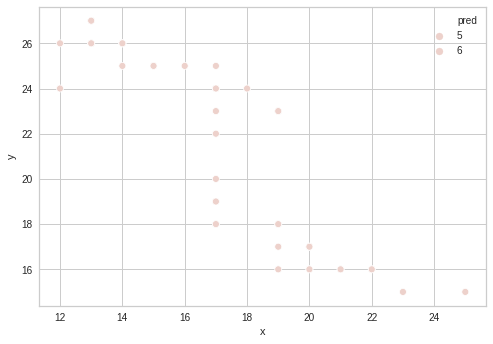

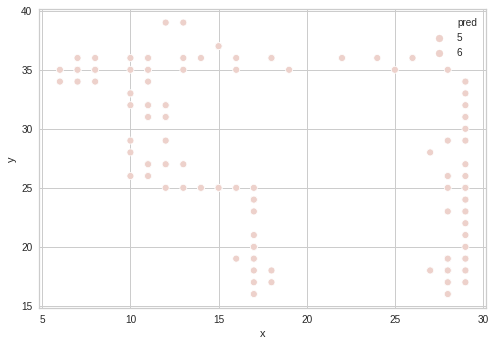

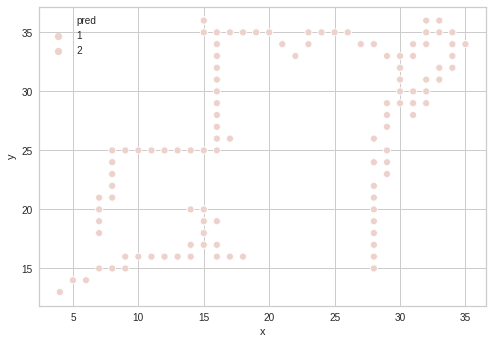

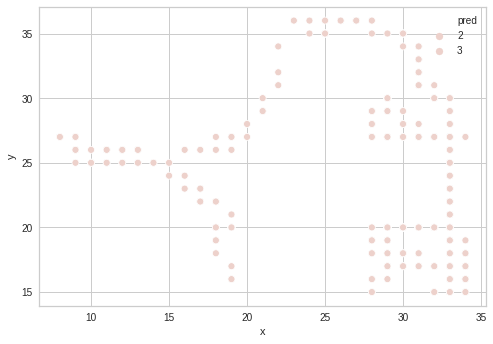

In [24]:
import matplotlib.pyplot as plt
for ajo in df["ajokerta"].unique()[:10]:
    
    plot = df[df["ajokerta"] == ajo]
    sns.scatterplot(x="x", y="y", data = plot, hue="pred")
    plt.show()

#### Plot heatmaps of classified routes to see are there some major differences.

188397


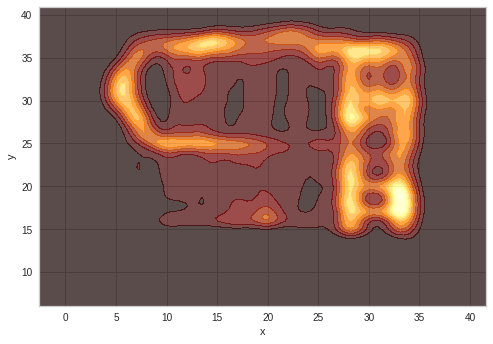

191797


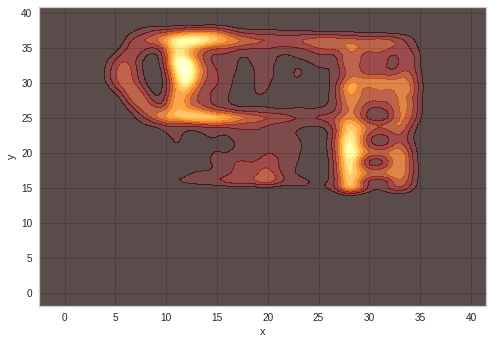

358673


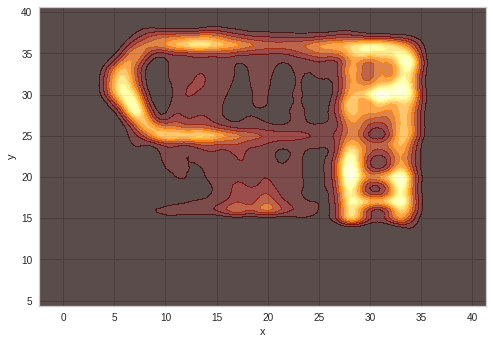

469559


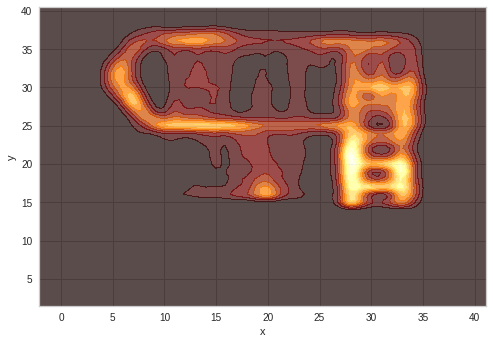

1012


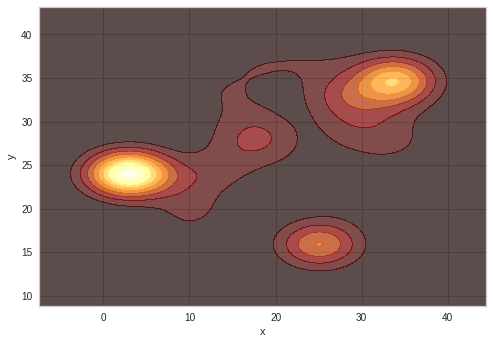

212091


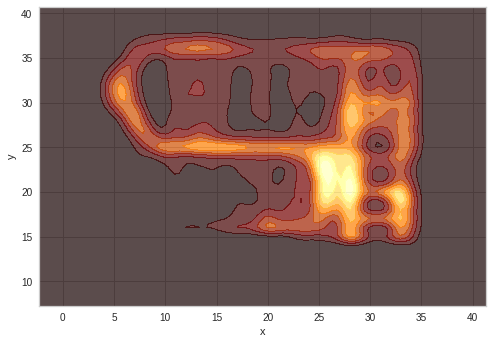

387650


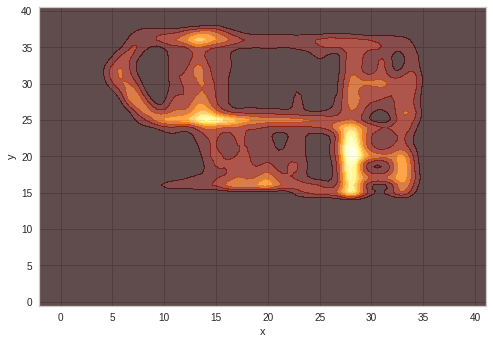

480386


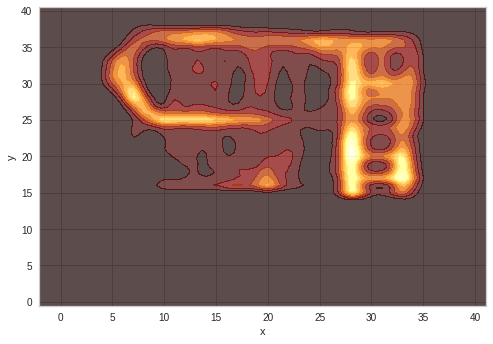

471686


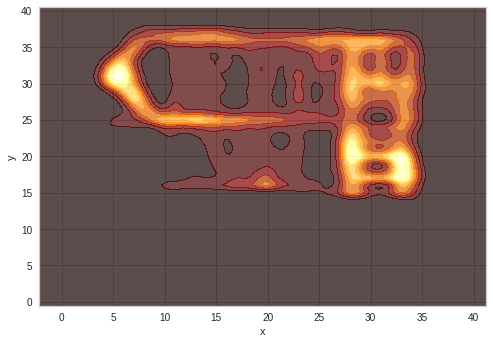

In [26]:
for i in range(len(df.pred.unique())):
    df1= df[df["pred"] == i]
    print(len(df1))
    sns.kdeplot(df1.x, df1.y, cmap="afmhot", shade=True, alpha = 0.7);
    plt.show()

### K-Medoids
##### pip install scikit-learn-extra

### Number of clusters

#### Elbow Method

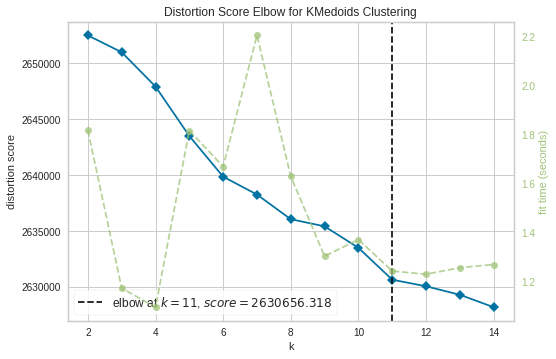

CPU times: user 33.1 s, sys: 10.3 s, total: 43.4 s
Wall time: 20.1 s


In [27]:
%%time
from sklearn_extra.cluster import KMedoids
kmetoids = KMedoids()
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmetoids, k=(2,15), timings= True)
visualizer.fit(std_df)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure
plt.show()

#### Silhouette Score

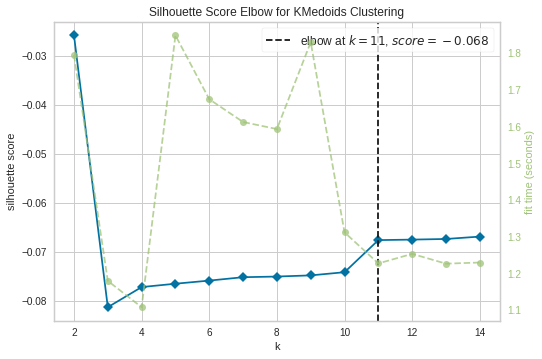

CPU times: user 52.6 s, sys: 13.1 s, total: 1min 5s
Wall time: 30.2 s


In [28]:
%%time
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmetoids, k=(2,15),metric='silhouette', timings= True)
visualizer.fit(std_df)        # Fit the data to the visualizer
visualizer.show()       # Finalize and render the figure
plt.show()

#### Calinski Harabasz Score

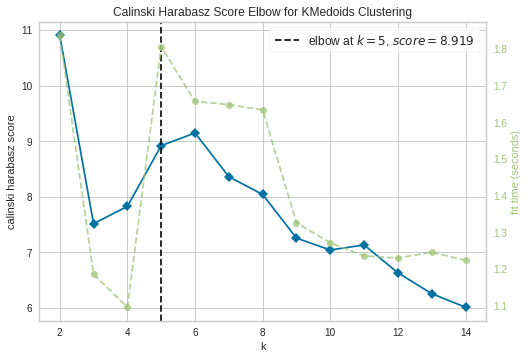

CPU times: user 31.1 s, sys: 9.04 s, total: 40.2 s
Wall time: 19.3 s


In [29]:
%%time
visualizer = KElbowVisualizer(kmetoids, k=(2,15),metric='calinski_harabasz', timings= True)
visualizer.fit(std_df)        # Fit the data to the visualizer
visualizer.show()    # Finalize and render the figure
plt.show()

In [30]:
kmeans = KMedoids(n_clusters=11, random_state=0).fit(std_df)
y_pred= kmeans.labels_

data["pred"] = y_pred
df["pred"] = df['ajokerta'].map(dict(zip(data.ajokerta,data.pred)))
df["pred"].value_counts()

2     1560852
3      278157
1      268450
5      170586
9      115988
10      85770
4       71412
8       67343
6       63099
0       43167
7       36427
Name: pred, dtype: int64

### Results
#### Plot heatmaps of classified routes to see are there some major differences.

43167


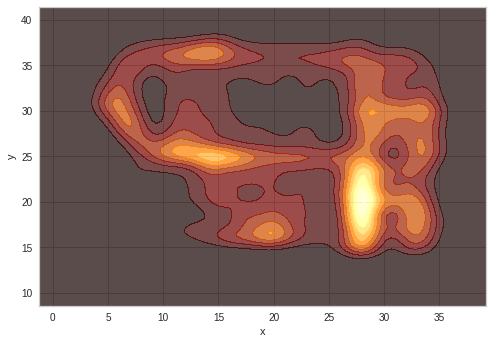

268450


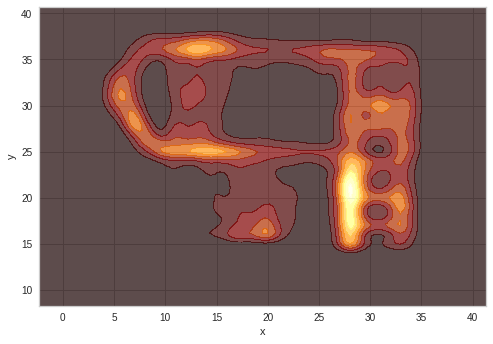

1560852


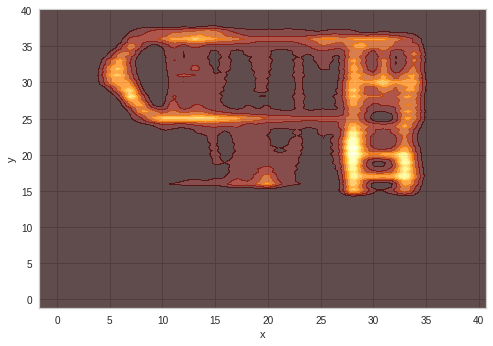

278157


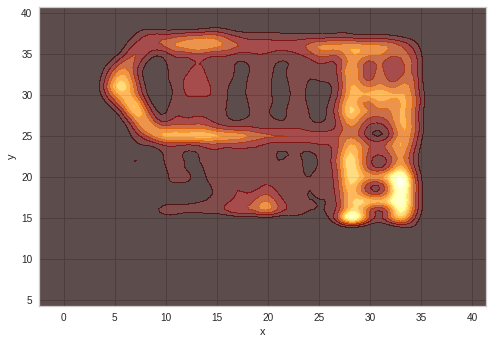

71412


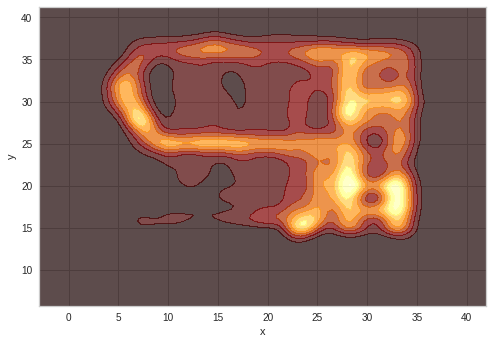

170586


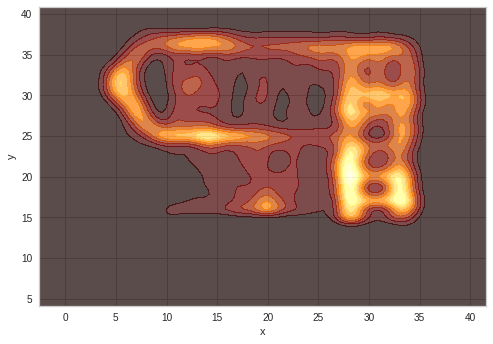

63099


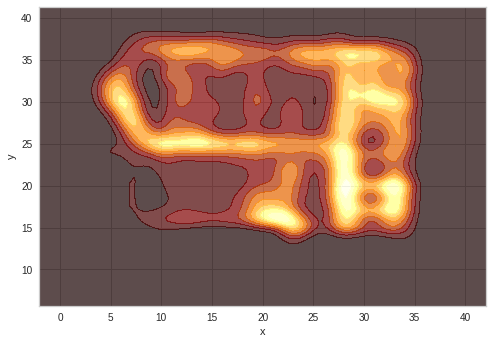

36427


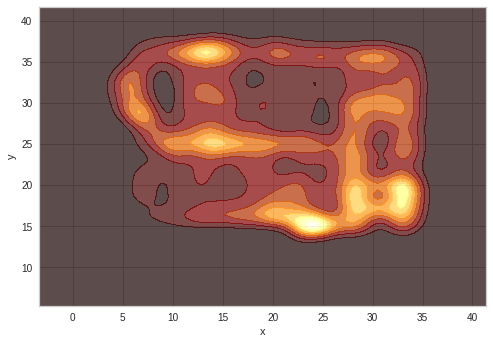

67343


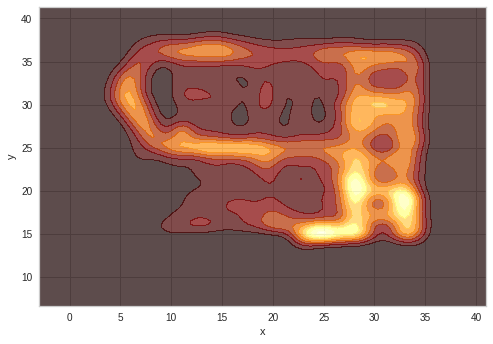

115988


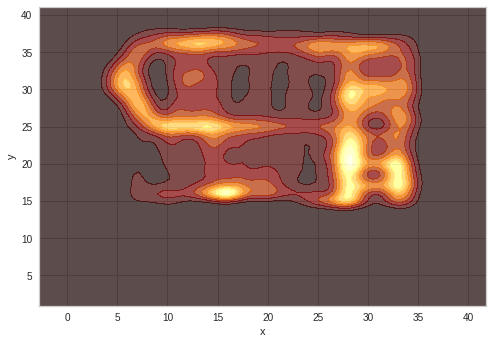

85770


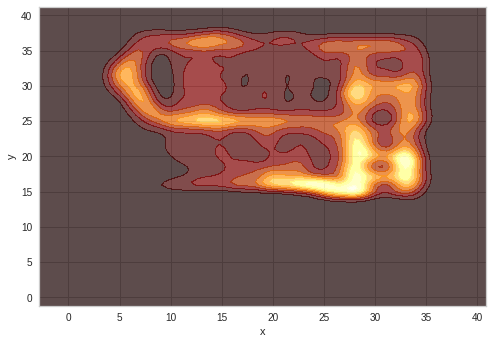

In [31]:
for i in range(len(df.pred.unique())):
    df1= df[df["pred"] == i]
    print(len(df1))
    sns.kdeplot(df1.x, df1.y, cmap="afmhot", shade=True, alpha = 0.7);
    plt.show()